# Kish Bank Halite

https://hyss.ie/

In [1]:
import os
from zipfile import BadZipFile, ZipFile
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rxr
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import pooch
import glob
from datetime import datetime, timezone
from shapely.geometry import Polygon

In [2]:
# base data download directory
SUB_DIR = os.path.join("data", "kish-basin")
os.makedirs(SUB_DIR, exist_ok=True)

URL = "https://hyss.ie/wp-content/uploads/2023/07/Kish-Basin-dat-files.zip"
KNOWN_HASH = None
FILE_NAME = "Kish-Basin-dat-files.zip"

DATA_FILE = os.path.join(SUB_DIR, FILE_NAME)

# boundary data
ie = gpd.read_file(
    os.path.join("data", "boundaries", "ref-nuts-2021-01m.gpkg"),
    layer="NUTS_RG_01M_2021_4326_IE"
)

In [3]:
# download data if necessary
if not os.path.isfile(DATA_FILE):
    pooch.retrieve(
        url=URL,
        known_hash=KNOWN_HASH,
        fname=FILE_NAME,
        path=SUB_DIR
    )

    with open(f"{DATA_FILE[:-4]}.txt", "w", encoding="utf-8") as outfile:
        outfile.write(
            f"Data downloaded on: {datetime.now(tz=timezone.utc)}\n"
            f"Download URL: {URL}"
        )

SHA256 hash of downloaded file: 73b3c35059540638bb4f2f85a8417a7bdff051c7f9564880fa71e8c54fcb9f35
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [3]:
ZipFile(DATA_FILE).namelist()

['Flyde Halite Base Depth XYZ Meters.dat',
 'Flyde Halite Thickness - Zone Of Interest - XYZ Meters.dat',
 'Flyde Halite Thickness XYZ Meters.dat',
 'Flyde Halite Top Depth XYZ Meters.dat',
 'Flyde Halite Top TWT XYZ Milliseconds.dat',
 'Kish GIS Map Extent - Square.csv',
 'Mythop Halite Base Depth XYZ Meters.dat',
 'Mythop Halite Thickness XYZ Meters.dat',
 'Mythop Halite Top Depth XYZ Meters.dat',
 'Mythop Halite Top TWT XYZ Milliseconds.dat',
 'Presall Halite Base Depth XYZ Meters-corrected.dat',
 'Presall Halite Thickness - Zone Of Interest - XYZ Meters-corrected.dat',
 'Presall Halite Thickness XYZ Meters-corrected.dat',
 'Presall Halite Top Depth XYZ Meters-corrected.dat',
 'Presall Halite Top TWT XYZ Milliseconds.dat',
 'Rossall Halite Base Depth XYZ Meters.dat',
 'Rossall Halite Thickness - Zone Of Interest - XYZ Meters.dat',
 'Rossall Halite Thickness XYZ Meters.dat',
 'Rossall Halite Top Depth XYZ Meters.dat',
 'Rossall Halite Top TWT XYZ Milliseconds.dat']

In [4]:
try:
    z = ZipFile(DATA_FILE)
    z.extractall(SUB_DIR)
except BadZipFile:
    print("There were issues with the file", DATA_FILE)

## Map extent

In [5]:
with open(os.path.join(SUB_DIR, "Kish GIS Map Extent - Square.csv")) as f:
    print(f.read())

Polygon exported from Kingdom on Thu Nov  3 20:00:33 2022
Coordinate System: ED50 / UTM zone 29N   EPSG: 23029
Polygon Name, Index, X, Y
AREA OF INTEREST,1,742000.000000,5937000.000000
AREA OF INTEREST,2,687000.000000,5937000.000000
AREA OF INTEREST,3,687000.000000,5888000.000000
AREA OF INTEREST,4,742000.000000,5888000.000000
AREA OF INTEREST,5,742000.000000,5937000.000000



In [6]:
extent = pd.read_csv(
    os.path.join(SUB_DIR, "Kish GIS Map Extent - Square.csv"), skiprows=2
)
extent = gpd.GeoSeries(
    Polygon([
        (extent[" X"][0], extent[" Y"][0]),
        (extent[" X"][1], extent[" Y"][1]),
        (extent[" X"][2], extent[" Y"][2]),
        (extent[" X"][3], extent[" Y"][3])
    ]),
    crs=23029
)

In [7]:
# extent = pd.read_csv(
#     os.path.join(SUB_DIR, "Kish GIS Map Extent - Square.csv"), skiprows=2
# )
# extent["wkt"] = (
#     "POINT (" + extent[" X"].astype(str) + " " +
#     extent[" Y"].astype(str) + ")"
# )
# extent = gpd.GeoDataFrame(
#     extent, geometry=gpd.GeoSeries.from_wkt(extent["wkt"]), crs=23029
# )
# extent.drop(columns=["wkt"], inplace=True)

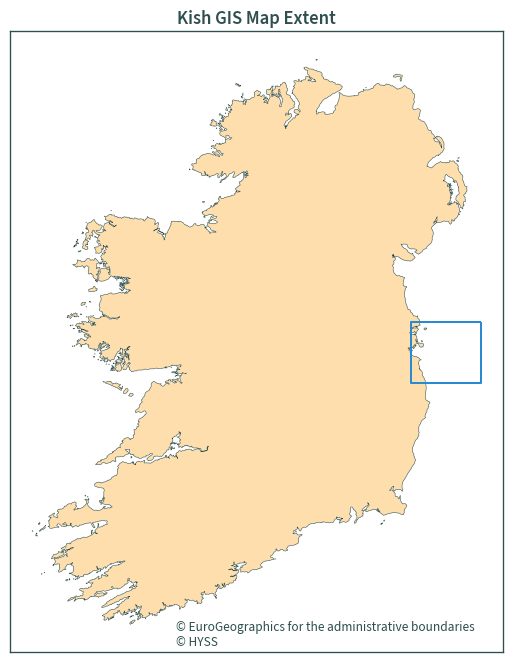

In [8]:
ax = ie.to_crs(23029).plot(
    color="navajowhite", figsize=(7, 7),
    edgecolor="darkslategrey", linewidth=.4
)
extent.boundary.plot(ax=ax)

plt.title("Kish GIS Map Extent")
plt.text(
    500000, 5.68e6,
    "© EuroGeographics for the administrative boundaries\n"
    "© HYSS"
)
plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

## XYZ data

In [9]:
def read_dat_file(dat_path: str, crs: int = 23029):
    ds = {}
    for dat_file in glob.glob(dat_path):
        dat = pd.read_fwf(dat_file, header=None, names=["X", "Y", "Z"])
        dat["wkt"] = (
            "POINT (" + dat["X"].astype(str) + " " + dat["Y"].astype(str) +
            " " + dat["Z"].astype(str) + ")"
        )
        dat = gpd.GeoDataFrame(
            dat, geometry=gpd.GeoSeries.from_wkt(dat["wkt"]), crs=crs
        )
        dat.drop(columns=["wkt"], inplace=True)

        ds[os.path.split(dat_file)[1][:-4]] = (
            dat[["X", "Y", "Z"]].set_index(["X", "Y"]).to_xarray()
        )
        ds[os.path.split(dat_file)[1][:-4]] = (
            ds[os.path.split(dat_file)[1][:-4]].assign_coords(
                data=(
                    os.path.split(dat_file)[1][:-4].replace(
                        " XYZ ", "\n"
                    ).replace(" -\n", "\n")
                )
            ).expand_dims(dim="data")
        )

    ds = xr.combine_by_coords(ds.values(), combine_attrs="override")
    ds.rio.write_crs(crs, inplace=True)

    return ds

In [10]:
ds = read_dat_file(os.path.join(SUB_DIR, "*.dat"))

In [11]:
ds

<xarray.Dataset>
Dimensions:      (X: 218, Y: 237, data: 19)
Coordinates:
  * X            (X) float64 6.966e+05 6.968e+05 6.97e+05 ... 7.398e+05 7.4e+05
  * Y            (Y) float64 5.889e+06 5.889e+06 ... 5.936e+06 5.936e+06
  * data         (data) <U60 'Flyde Halite Base Depth\nMeters' ... 'Rossall H...
    spatial_ref  int64 0
Data variables:
    Z            (data, X, Y) float64 nan nan nan nan nan ... nan nan nan nan

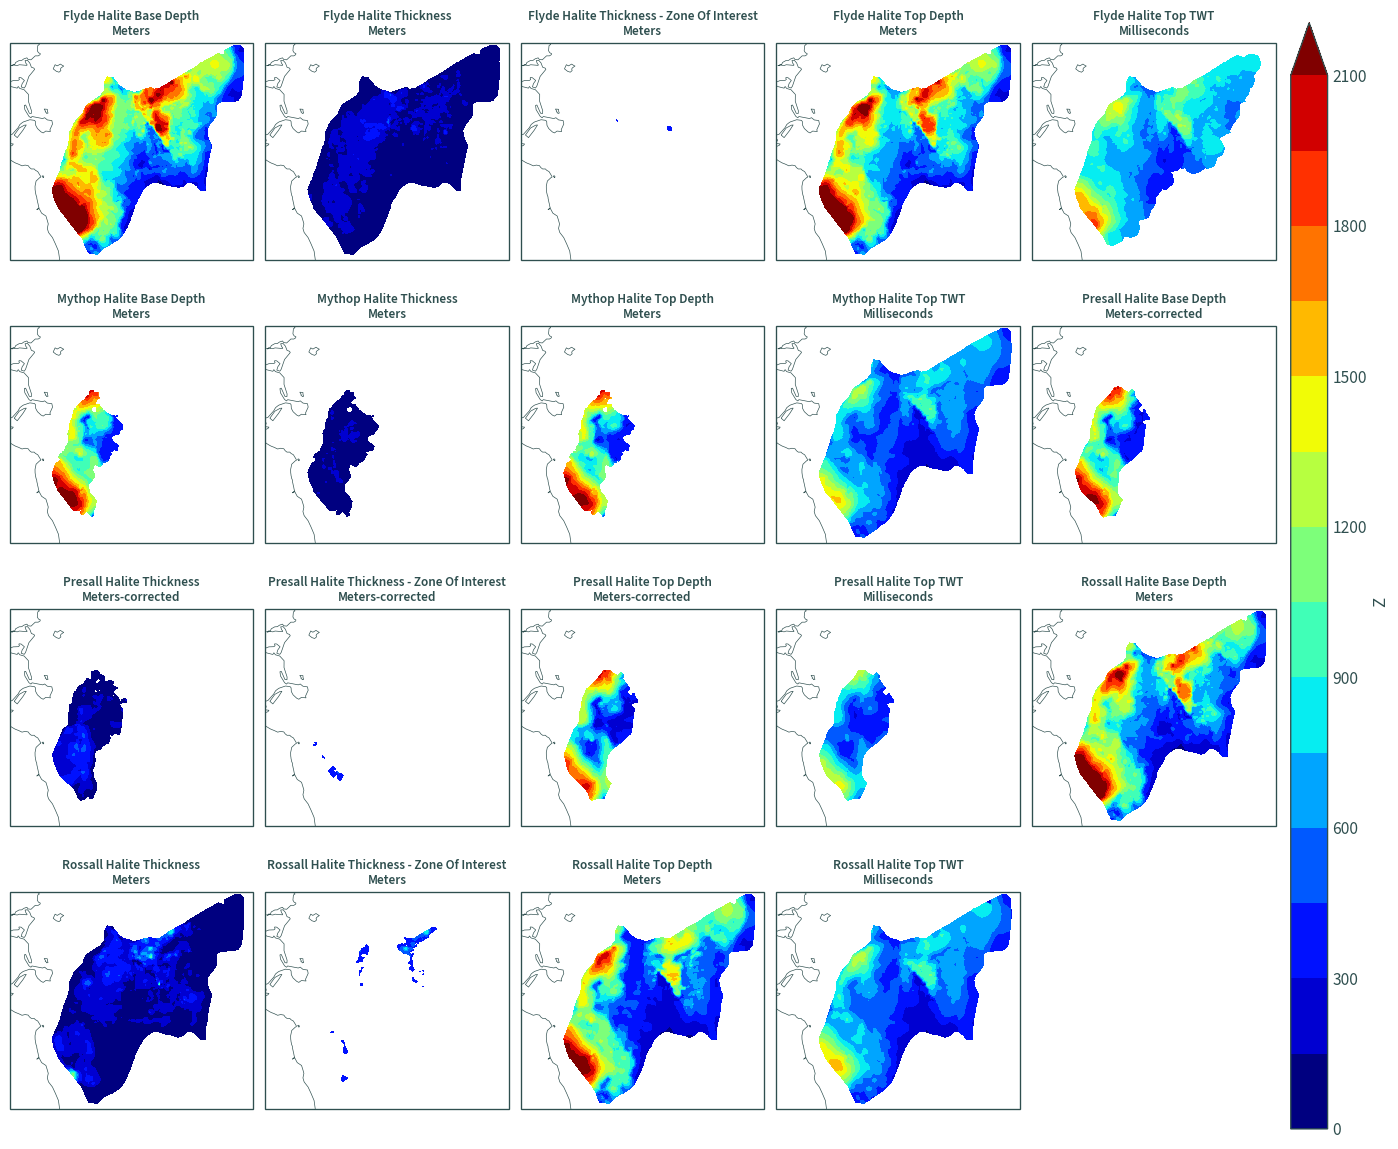

In [12]:
fig = ds["Z"].plot.contourf(
    x="X", y="Y", col="data",
    cmap="jet", col_wrap=5, robust=True, levels=15,
    subplot_kws={"projection": ccrs.epsg(23029)},
    transform=ccrs.epsg(23029),
    xlim=(687000, 742000), ylim=(5888000, 5937000),
    cbar_kwargs={"aspect": 30, "pad": 0.01}
)
for axis in fig.axs.flat:
    ie.to_crs(23029).boundary.plot(
        ax=axis, edgecolor="darkslategrey", linewidth=.5
    )
# fig.set_titles("{value}", fontsize=10)
for ax, title in zip(fig.axs.flat, ds["data"].values):
    ax.set_title(title, fontsize=10)
plt.show()

In [13]:
# for d in ds["data"].values:
#     plt.figure(figsize=(9, 7))
#     ax = plt.axes(projection=ccrs.epsg(23029))
#     ds.sel(data=d)["Z"].plot.contourf(x="X", y="Y", cmap="Spectral_r", robust=True)
#     ie.to_crs(23029).boundary.plot(ax=ax, color="darkslategrey", linewidth=1)
#     plt.title(d)
#     plt.xlim(657000, 772000)
#     plt.ylim(5858000, 5967000)
#     # plt.axis("equal")
#     plt.tight_layout()
#     plt.show()

In [14]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ds = ds.isel(data=0)
# ax.plot_trisurf(ds.X, ds.Y, ds.Z, cmap="Spectral_r")
# plt.axis("equal")
# plt.tight_layout()
# plt.show()